In [30]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import cross_validation
from sklearn.decomposition import PCA
from sklearn.grid_search import GridSearchCV

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

<h1> Loading a data frame with business ids and restrant labels

In [2]:
df_train_labels = pd.DataFrame.from_csv('train.csv')
df_train_labels.reset_index(level=0, inplace=True)
df_train_labels.head(5)

,business_id,labels
0,1000,1 2 3 4 5 6 7
1,1001,0 1 6 8
2,100,1 2 4 5 6 7
3,1006,1 2 4 5 6
4,1010,0 6 8


<h1> Loading mean CNN codes

<h2> Features used in classifying

In [3]:
def df_train_for_classifier(layer, df_train_labels):
    name_df = 'df_train_'+layer
    df = pd.read_pickle(name_df)
    df.reset_index(level=0, inplace=True)
    df = pd.merge(df, df_train_labels, on = 'business_id')
    df = df.dropna(how = 'any')
    df['meanCNN'] = df['meanCNN'].apply(lambda x: list(x))
    
    data = df['meanCNN']
    data = np.array([x for x in data])
    
    df['labels'] = df['labels'].apply(lambda x: map(float, x.split(' ')))
    labels = MultiLabelBinarizer().fit_transform(df['labels'])
    labels[0:5]
    
    return data, labels

In [4]:
train_data_fc6, train_labels = df_train_for_classifier('fc6', df_train_labels)
train_data_fc7, train_labels = df_train_for_classifier('fc7', df_train_labels)
train_data_fc8, train_labels = df_train_for_classifier('fc8', df_train_labels)
train_data_prob, train_labels = df_train_for_classifier('prob', df_train_labels)

In [5]:
features_combinations = [train_data_fc6, train_data_fc7, train_data_fc8, train_data_prob, 
                         np.hstack((train_data_fc6, train_data_fc7)), np.hstack((train_data_fc7, train_data_fc8)),
                        np.hstack((train_data_fc8, train_data_prob)), np.hstack((train_data_fc6, train_data_fc8)),
                        np.hstack((train_data_fc6, train_data_prob)), np.hstack((train_data_fc7, train_data_prob)),
                        np.hstack((train_data_fc6, train_data_fc7, train_data_fc8)), 
                        np.hstack((train_data_fc7, train_data_fc8, train_data_prob)),
                        np.hstack((train_data_fc6, train_data_fc8, train_data_prob)),
                         np.hstack((train_data_fc6, train_data_fc7, train_data_prob)),
                        np.hstack((train_data_fc6, train_data_fc7, train_data_fc8, train_data_prob)),]

In [6]:
features_names = ['fc6', 'fc7', 'fc8', 'prob', 'fc6_fc7', 'fc7_fc8','fc8_prob', 'fc6_fc8',
                        'fc6_prob', 'fc7_prob','fc6_fc7_fc8','fc7_fc8_prob','fc6_fc8_prob',
                         'fc6_fc7_prob','fc6_fc7_fc8_prob']

In [7]:
features = dict(zip(features_names, features_combinations))

<h1> Training classifiers

In [20]:
##Cross-validation
kf = cross_validation.KFold(n = 1996, n_folds = 5)

<h2> Logistic Regression

<h3> Testing performance of PCA decomposition on features

In [48]:
def cv_pca_decomp(clf, data, labels, n_comp_ar):
    kf = cross_validation.KFold(n = 1996, n_folds = 5)
    meanscores_pca = []
    meanscore_def = np.mean(cross_validation.cross_val_score(clf, data, labels, cv = kf, scoring = 'f1'))
    
    for n in n_comp_ar:
        if data.shape[1] > n:
            data_reduced = PCA(n_components=n).fit_transform(data)
            score = np.mean(cross_validation.cross_val_score(clf, data_reduced, labels, cv = kf, scoring = 'f1'))
            meanscores_pca.append(score)
        else:
            meanscores_pca.append(np.nan)
    
    return meanscore_def, meanscores_pca

In [49]:
clf = OneVsRestClassifier(LogisticRegression())

In [50]:
n_comp_ar = [100, 250, 500, 1000, 2000]

In [51]:
cv_score_pca_log_reg = {}
for data, name in zip(features_combinations, features_names):
    print(name)
    clf = OneVsRestClassifier(LogisticRegression())
    meanscore_def, meanscores_pca = cv_pca_decomp(clf, data, train_labels, n_comp_ar)
    cv_score_pca_log_reg[name] = [meanscore_def, meanscores_pca]

C:\Users\asr1g12\Anaconda3\envs\py27\lib\site-packages\sklearn\metrics\classification.py:756: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
C:\Users\asr1g12\Anaconda3\envs\py27\lib\site-packages\sklearn\metrics\classification.py:756: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scori

fc6
fc7

C:\Users\asr1g12\Anaconda3\envs\py27\lib\site-packages\sklearn\metrics\classification.py:756: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
C:\Users\asr1g12\Anaconda3\envs\py27\lib\site-packages\sklearn\metrics\classification.py:756: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scori


fc8

C:\Users\asr1g12\Anaconda3\envs\py27\lib\site-packages\sklearn\metrics\classification.py:756: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
C:\Users\asr1g12\Anaconda3\envs\py27\lib\site-packages\sklearn\metrics\classification.py:756: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scori


prob

C:\Users\asr1g12\Anaconda3\envs\py27\lib\site-packages\sklearn\metrics\classification.py:756: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
C:\Users\asr1g12\Anaconda3\envs\py27\lib\site-packages\sklearn\metrics\classification.py:756: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scori


fc6_fc7

C:\Users\asr1g12\Anaconda3\envs\py27\lib\site-packages\sklearn\metrics\classification.py:756: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
C:\Users\asr1g12\Anaconda3\envs\py27\lib\site-packages\sklearn\metrics\classification.py:756: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scori


fc7_fc8

C:\Users\asr1g12\Anaconda3\envs\py27\lib\site-packages\sklearn\metrics\classification.py:756: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
C:\Users\asr1g12\Anaconda3\envs\py27\lib\site-packages\sklearn\metrics\classification.py:756: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scori


fc8_prob

C:\Users\asr1g12\Anaconda3\envs\py27\lib\site-packages\sklearn\metrics\classification.py:756: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
C:\Users\asr1g12\Anaconda3\envs\py27\lib\site-packages\sklearn\metrics\classification.py:756: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scori


fc6_fc8

C:\Users\asr1g12\Anaconda3\envs\py27\lib\site-packages\sklearn\metrics\classification.py:756: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
C:\Users\asr1g12\Anaconda3\envs\py27\lib\site-packages\sklearn\metrics\classification.py:756: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scori


fc6_prob

C:\Users\asr1g12\Anaconda3\envs\py27\lib\site-packages\sklearn\metrics\classification.py:756: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
C:\Users\asr1g12\Anaconda3\envs\py27\lib\site-packages\sklearn\metrics\classification.py:756: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scori


fc7_prob

C:\Users\asr1g12\Anaconda3\envs\py27\lib\site-packages\sklearn\metrics\classification.py:756: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
C:\Users\asr1g12\Anaconda3\envs\py27\lib\site-packages\sklearn\metrics\classification.py:756: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scori


fc6_fc7_fc8

C:\Users\asr1g12\Anaconda3\envs\py27\lib\site-packages\sklearn\metrics\classification.py:756: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
C:\Users\asr1g12\Anaconda3\envs\py27\lib\site-packages\sklearn\metrics\classification.py:756: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scori


fc7_fc8_prob

C:\Users\asr1g12\Anaconda3\envs\py27\lib\site-packages\sklearn\metrics\classification.py:756: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
C:\Users\asr1g12\Anaconda3\envs\py27\lib\site-packages\sklearn\metrics\classification.py:756: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scori


fc6_fc8_prob

C:\Users\asr1g12\Anaconda3\envs\py27\lib\site-packages\sklearn\metrics\classification.py:756: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
C:\Users\asr1g12\Anaconda3\envs\py27\lib\site-packages\sklearn\metrics\classification.py:756: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scori


fc6_fc7_prob

C:\Users\asr1g12\Anaconda3\envs\py27\lib\site-packages\sklearn\metrics\classification.py:756: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
C:\Users\asr1g12\Anaconda3\envs\py27\lib\site-packages\sklearn\metrics\classification.py:756: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scori


fc6_fc7_fc8_prob

C:\Users\asr1g12\Anaconda3\envs\py27\lib\site-packages\sklearn\metrics\classification.py:756: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
C:\Users\asr1g12\Anaconda3\envs\py27\lib\site-packages\sklearn\metrics\classification.py:756: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scori

In [52]:
df_cv_score_pca_log_reg = pd.DataFrame(cv_score_pca_log_reg)

In [53]:
#df_cv_score_pca_log_reg.to_pickle('df_cv_score_pca_log_reg')

In [53]:
df_cv_score_pca_log_reg = pd.read_pickle('df_cv_score_pca_log_reg')

In [55]:
df_cv_score_pca_log_reg = df_cv_score_pca_log_reg.append([df_cv_score_pca_log_reg.loc[1,]]*4)

In [56]:
df_cv_score_pca_log_reg = df_cv_score_pca_log_reg.set_index([['default','pca100','pca250','pca500','pca1000', 'pca2000']])

In [57]:
df_cv_score_pca_log_reg.loc['pca100',:] = df_cv_score_pca_log_reg.loc['pca100',:].apply(lambda x: x[0])
df_cv_score_pca_log_reg.loc['pca250',:] = df_cv_score_pca_log_reg.loc['pca250',:].apply(lambda x: x[1])
df_cv_score_pca_log_reg.loc['pca500',:] = df_cv_score_pca_log_reg.loc['pca500',:].apply(lambda x: x[2])
df_cv_score_pca_log_reg.loc['pca1000',:] = df_cv_score_pca_log_reg.loc['pca1000',:].apply(lambda x: x[3])
df_cv_score_pca_log_reg.loc['pca2000',:] = df_cv_score_pca_log_reg.loc['pca2000',:].apply(lambda x: x[4])

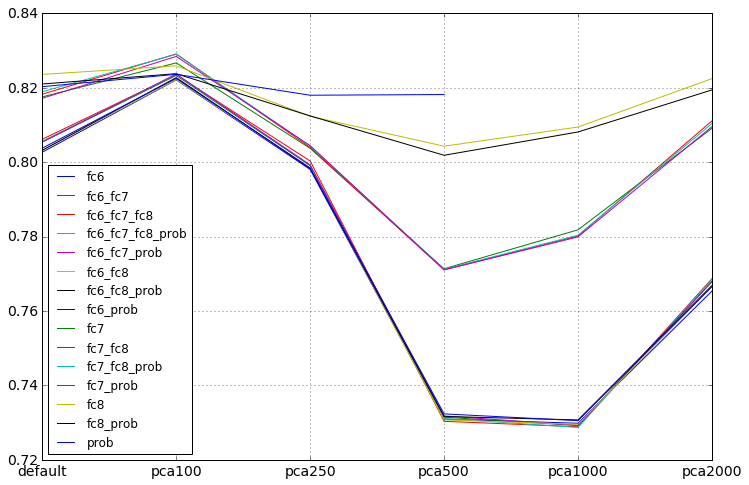

In [77]:
df_cv_score_pca_log_reg.plot(figsize = (12,8), grid=True, fontsize=14)

In [60]:
df_cv_score_pca_log_reg.idxmax()

fc6                 pca100
fc6_fc7             pca100
fc6_fc7_fc8         pca100
fc6_fc7_fc8_prob    pca100
fc6_fc7_prob        pca100
fc6_fc8             pca100
fc6_fc8_prob        pca100
fc6_prob            pca100
fc7                 pca100
fc7_fc8             pca100
fc7_fc8_prob        pca100
fc7_prob            pca100
fc8                 pca100
fc8_prob            pca100
prob                pca100
dtype: object

In [72]:
df_cv_score_pca_log_reg.loc['pca100',].sort(ascending=False, inplace=False)

C:\Users\asr1g12\Anaconda3\envs\py27\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: sort is deprecated, use sort_values(inplace=True) for for INPLACE sorting
  if __name__ == '__main__':


fc7_fc8             0.829107
fc7_fc8_prob        0.828999
fc7_prob            0.828429
fc7                 0.826697
fc8                 0.825897
fc8_prob            0.823796
fc6_fc7_prob        0.823688
prob                0.823624
fc6_fc7_fc8_prob     0.82358
fc6_fc7_fc8         0.823484
fc6_fc7             0.823335
fc6_fc8_prob        0.822746
fc6_prob            0.822533
fc6_fc8             0.822197
fc6                 0.822139
Name: pca100, dtype: object

-----------------------------------------

PCA decomposition to 100 components shows the best result for the Logistic Regression classifier for all combinations of features. The best performing combination of features is outcome from layer fc7 concated with the outcome from layer fc8

In [8]:
train_data_reduced = PCA(n_components=100).fit_transform(features['fc7_fc8'])

<h3> Selecting the best parameters for Logistic regression classifier

In [162]:
param_grid_log_reg = {"estimator__C": [0.001, 0.01, 0.05, 0.1, 0.5, 1, 10,100],
                     "estimator__penalty": ['l1', 'l2']}

In [163]:
grid = GridSearchCV(OneVsRestClassifier(LogisticRegression()), param_grid_log_reg, scoring='f1')

In [164]:
grid = grid.fit(train_data_reduced, train_labels)

In [165]:
grid.best_params_

{'estimator__C': 0.05, 'estimator__penalty': 'l1'}

In [166]:
grid.best_score_

0.82818099937052658

<h2> Support vector classifier

<h3> Selecting the best parameters for SVC

In [167]:
param_grid_svc = [
  {'estimator__C': [0.1, 1, 10, 100], 'estimator__kernel': ['linear']},
  {'estimator__C': [0.1, 1, 10, 100], 'estimator__gamma': [0.001, 0.0001], 'estimator__kernel': ['rbf']},
 ]

In [169]:
grid_svc = GridSearchCV(OneVsRestClassifier(SVC()), param_grid_svc, scoring='f1')

In [170]:
grid_svc = grid_svc.fit(train_data_reduced, train_labels)

In [171]:
grid_svc.best_params_

{'estimator__C': 1, 'estimator__gamma': 0.0001, 'estimator__kernel': 'rbf'}

In [172]:
grid_svc.best_score_

0.83254616393949765

In [173]:
import pickle

f = open('grid_svc_best_params.pckl', 'w')
pickle.dump(grid_svc.best_params_, f)
f.close()

f = open('grid_svc_best_score.pckl', 'w')
pickle.dump(grid_svc.best_score_, f)
f.close()

<h2> Decision tree classifier

In [24]:
clf_dt = OneVsRestClassifier(DecisionTreeClassifier())
param_grid_dt = {'estimator__min_samples_split': [1,100,500,1000,1500,2000],
              'estimator__max_depth':[2,6,10,100]}

In [25]:
#clf_dt = clf_dt.fit(train_data_reduced, train_labels)
grid_dt = GridSearchCV(clf_dt, param_grid_dt, cv=5, scoring='f1')

In [26]:
grid_dt = grid_dt.fit(train_data_reduced, train_labels)

In [27]:
grid_dt.best_params_

{'estimator__max_depth': 6, 'estimator__min_samples_split': 100}

In [28]:
grid_dt.best_score_

0.77097719131744691

In [29]:
import pickle

f = open('grid_dt_best_params.pckl', 'w')
pickle.dump(grid_dt.best_params_, f)
f.close()

f = open('grid_dt_best_score.pckl', 'w')
pickle.dump(grid_dt.best_score_, f)
f.close()

<h2> K Nearest Neighbourgh

In [32]:
clf_knn = OneVsRestClassifier(KNeighborsClassifier())
param_grid_knn = {'estimator__n_neighbors': [2,5,10,20,40,50,70],
              'estimator__algorithm':['auto', 'ball_tree', 'kd_tree', 'brute']}

In [33]:
grid_knn = GridSearchCV(clf_knn, param_grid_knn, cv=5, scoring='f1')

In [34]:
grid_knn = grid_knn.fit(train_data_reduced, train_labels)

In [35]:
grid_knn.best_params_

{'estimator__algorithm': 'auto', 'estimator__n_neighbors': 10}

In [36]:
grid_knn.best_score_

0.80534865720588278